In [25]:
# Import packages
import pandas as pd
import numpy as np
import datetime
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, cohen_kappa_score, f1_score
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE, SMOTENC
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.decomposition import PCA
from scipy import stats
from math import sqrt



import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, GaussianNoise
from keras.optimizers import SGD
from keras import regularizers

In [2]:
path = "/Users/Stijn/Documents/Master Data Science and Society/Block 3/thesis/code/thesis_Code/"
mood = pd.read_csv(path+'mood_imputed_median.csv', sep = ',', index_col=0)
mood['content_last'] = mood.groupby('user_id')['content'].shift()
mood.loc[(pd.isnull(mood.content_last)), 'content_last'] = mood['content']
mood_content = mood.drop(["anxious", "bored", "cheerful", "user_id", "response_time"], axis=1)

In [3]:
mood_content[:5]

,content,day_time_window,average_TimeUse,bulk,messaging,socialnetworking,otherapp,content_last
4825,4.0,3.0,0.673000,0,0,0,1,4.0
4826,4.0,4.0,64.314667,0,1,0,2,4.0
245,4.0,1.0,20.590500,0,0,0,2,4.0
4827,4.0,2.0,0.000000,0,0,0,0,4.0
4828,4.0,3.0,53.957200,0,3,0,2,4.0


In [4]:
# Normalize predictors
mood_normz = mood_content.copy()
features_to_normalize = ['day_time_window', 'average_TimeUse', 'messaging', 'socialnetworking', 'otherapp']
mood_normz[features_to_normalize] = mood_normz[features_to_normalize].apply(lambda x:(x-x.min()) / (x.max()-x.min()))

In [5]:
X = mood_normz.iloc[:,1:]
y = mood_normz.iloc[:, 0:1]
y = y.astype(int)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [7]:
X_train[:5]

,day_time_window,average_TimeUse,bulk,messaging,socialnetworking,otherapp,content_last
10315,1.000000,0.000000,0,0.000000,0.00,0.0,3.0
15108,1.000000,0.024319,0,0.009524,0.02,0.0,4.0
1524,0.000000,0.000000,0,0.000000,0.00,0.0,1.0
5438,0.666667,0.000000,0,0.000000,0.00,0.0,2.0
992,0.000000,0.000000,0,0.000000,0.00,0.0,3.0


In [8]:
# Oversampling unbalanced target
print("Before OverSampling, counts of labels: {}".format(y_train['content'].value_counts()))
  
sm = SMOTENC(categorical_features=[0, 2, 6], random_state = 2) 
X_train_res, y_train_res = sm.fit_sample(X_train, y_train['content'].ravel()) 

print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0))) 
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '2': {}".format(sum(y_train_res == 2))) 
print("After OverSampling, counts of label '3': {}".format(sum(y_train_res == 3))) 
print("After OverSampling, counts of label '4': {}".format(sum(y_train_res == 4))) 
print("After OverSampling, counts of label '5': {}".format(sum(y_train_res == 5))) 

Before OverSampling, counts of labels: 3    3165
4    2379
2    2203
1    1261
0     872
5     696
Name: content, dtype: int64
After OverSampling, counts of label '0': 3165
After OverSampling, counts of label '1': 3165
After OverSampling, counts of label '2': 3165
After OverSampling, counts of label '3': 3165
After OverSampling, counts of label '4': 3165
After OverSampling, counts of label '5': 3165


In [9]:
X_train = pd.DataFrame(data=X_train_res)
y_train = pd.DataFrame(data=y_train_res)

In [10]:
# Shuffle both train and test set to cancel patterns
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)

In [11]:
X_train_nomood = X_train.iloc[:,:-1]
X_train_onlycontentlast = X_train.iloc[:,-1:]
X_test_nomood = X_test.iloc[:,:-1]
X_test_onlycontentlast = X_test.iloc[:,-1:]

In [12]:
# Define Keras model
model = Sequential()
model.add(Dense(24, input_dim=6, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(12, kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 24)                168       
_________________________________________________________________
dropout_1 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                300       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 13        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(X_train_nomood, y_train, epochs=100, validation_split=0.2, batch_size=512)

Train on 15192 samples, validate on 3798 samples
Epoch 1/100
15192/15192 [==============================] - 0s 17us/step - loss: 7.8522 - accuracy: 0.1669 - val_loss: 6.5565 - val_accuracy: 0.1790
Epoch 2/100
15192/15192 [==============================] - 0s 5us/step - loss: 5.6489 - accuracy: 0.1634 - val_loss: 4.4460 - val_accuracy: 0.1751
Epoch 3/100
15192/15192 [==============================] - 0s 5us/step - loss: 3.9200 - accuracy: 0.1666 - val_loss: 3.3465 - val_accuracy: 0.1654
Epoch 4/100
15192/15192 [==============================] - 0s 5us/step - loss: 3.3490 - accuracy: 0.1710 - val_loss: 3.2050 - val_accuracy: 0.1667
Epoch 5/100
15192/15192 [==============================] - 0s 5us/step - loss: 3.2461 - accuracy: 0.1747 - val_loss: 3.1296 - val_accuracy: 0.1659
Epoch 6/100
15192/15192 [==============================] - 0s 5us/step - loss: 3.1872 - accuracy: 0.1737 - val_loss: 3.0904 - val_accuracy: 0.1661
Epoch 7/100
15192/15192 [==============================] - 0s 5us/st

15192/15192 [==============================] - 0s 5us/step - loss: 2.9276 - accuracy: 0.1716 - val_loss: 2.9223 - val_accuracy: 0.1661
Epoch 57/100
15192/15192 [==============================] - 0s 4us/step - loss: 2.9206 - accuracy: 0.1705 - val_loss: 2.9221 - val_accuracy: 0.1656
Epoch 58/100
15192/15192 [==============================] - 0s 4us/step - loss: 2.9193 - accuracy: 0.1670 - val_loss: 2.9221 - val_accuracy: 0.1651
Epoch 59/100
15192/15192 [==============================] - 0s 5us/step - loss: 2.9192 - accuracy: 0.1693 - val_loss: 2.9290 - val_accuracy: 0.1596
Epoch 60/100
15192/15192 [==============================] - 0s 5us/step - loss: 2.9186 - accuracy: 0.1675 - val_loss: 2.9215 - val_accuracy: 0.1643
Epoch 61/100
15192/15192 [==============================] - 0s 5us/step - loss: 2.9163 - accuracy: 0.1698 - val_loss: 2.9206 - val_accuracy: 0.1656
Epoch 62/100
15192/15192 [==============================] - 0s 5us/step - loss: 2.9133 - accuracy: 0.1707 - val_loss: 2.9207 

In [14]:
score = model.evaluate(X_train_nomood, y_train, verbose=0)
print('Test loss:', round(score[0],4))
print('Test accuracy:', round(score[1]*100,2), "%")

Test loss: 2.8854
Test accuracy: 16.95 %


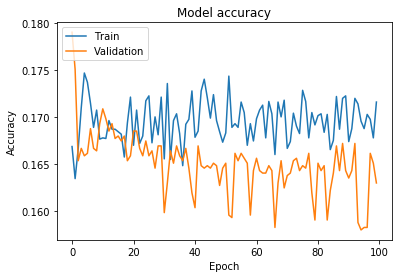

In [15]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

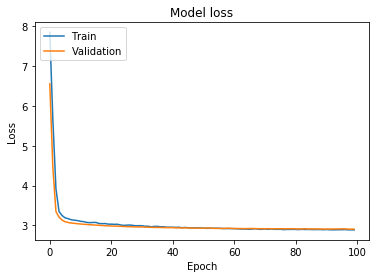

In [16]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [17]:
y_pred = model.predict(X_test_nomood)

In [18]:
pred = []
for a in y_pred:
    for b in a:
        pred.append(round(b))

test = []
for c in y_test['content']:
    test.append(c)


In [19]:
a = accuracy_score(pred,test)
print('Accuracy is:', a*100)

Accuracy is: 24.87712665406427


In [20]:
# true = y_test
# pred = y_pred
# last_value = X_content_lastarray
same_correct = 0
same_wrong = 0
dif_correct = 0
dif_wrong = 0

X_test_content = X_test_onlycontentlast['content_last'].values
for i in range(len(pred)):
    if (test[i] == X_test_content[i]) and (test[i] == pred[i]):
        same_correct += 1
    if (test[i] == X_test_content[i]) and (test[i] != pred[i]):
        same_wrong += 1
    if (test[i] != X_test_content[i]) and (test[i] == pred[i]):
        dif_correct += 1
    if (test[i] != X_test_content[i]) and (test[i] != pred[i]):
        dif_wrong += 1   

print("       ", "Same", "Dif")
print("correct", same_correct, dif_correct)
print("wrong  ", same_wrong, dif_wrong)

#Check if table is similar to accuracy
if (same_correct+dif_correct) / (same_correct+dif_correct+same_wrong+dif_wrong) == a:
    print("Table is right!")
else:
    print("Table is wrong")

        Same Dif
correct 403 255
wrong   1258 729
Table is right!


In [21]:
from collections import Counter
print("Predicted valxues: ", Counter(pred))
print("True values: ", Counter(test))
print("Previous mood:", Counter(X_test_content))

Predicted valxues:  Counter({2.0: 2075, 3.0: 569, 4.0: 1})
True values:  Counter({3: 807, 4: 579, 2: 572, 1: 298, 0: 218, 5: 171})
Previous mood: Counter({3.0: 786, 4.0: 590, 2.0: 576, 1.0: 294, 0.0: 215, 5.0: 184})


In [22]:
same_correct_0, same_wrong_0, same_correct_1, same_wrong_1, same_correct_2, same_wrong_2, same_correct_3, same_wrong_3, same_correct_4, same_wrong_4, same_correct_5, same_wrong_5 = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
dif_correct_0, dif_wrong_0, dif_correct_1, dif_wrong_1, dif_correct_2, dif_wrong_2, dif_correct_3, dif_wrong_3, dif_correct_4, dif_wrong_4, dif_correct_5, dif_wrong_5 = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

for i in range(len(pred)):
    if test[i] == 0 and pred[i] == 0:
        if test[i] == X_test_content[i]:
            same_correct_0 += 1
        if test[i] != X_test_content[i]:
            dif_correct_0 += 1
    if test[i] == 0 and pred[i] != 0:
        if test[i] == X_test_content[i]:
            same_wrong_0 += 1
        if test[i] != X_test_content[i]:
            dif_wrong_0 += 1

    if test[i] == 1 and pred[i] == 1:
        if test[i] == X_test_content[i]:
            same_correct_1 += 1
        if test[i] != X_test_content[i]:
            dif_correct_1 += 1
    if test[i] == 1 and pred[i] != 1:
        if test[i] == X_test_content[i]:
            same_wrong_1 += 1
        if test[i] != X_test_content[i]:
            dif_wrong_1 += 1
        
    if test[i] == 2 and pred[i] == 2:
        if test[i] == X_test_content[i]:
            same_correct_2 += 1
        if test[i] != X_test_content[i]:
            dif_correct_2 += 1
    if test[i] == 2 and pred[i] != 2:
        if test[i] == X_test_content[i]:
            same_wrong_2 += 1
        if test[i] != X_test_content[i]:
            dif_wrong_2 += 1
    
    if test[i] == 3 and pred[i] == 3:
        if test[i] == X_test_content[i]:
            same_correct_3 += 1
        if test[i] != X_test_content[i]:
            dif_correct_3 += 1
    if test[i] == 3 and pred[i] != 3:
        if test[i] == X_test_content[i]:
            same_wrong_3 += 1
        if test[i] != X_test_content[i]:
            dif_wrong_3 += 1
        
    if test[i] == 4 and pred[i] == 4:
        if test[i] == X_test_content[i]:
            same_correct_4 += 1
        if test[i] != X_test_content[i]:
            dif_correct_4 += 1
    if test[i] == 4 and pred[i] != 4:
        if test[i] == X_test_content[i]:
            same_wrong_4 += 1
        if test[i] != X_test_content[i]:
            dif_wrong_4 += 1
    
    if test[i] == 5 and pred[i] == 5:
        if test[i] == X_test_content[i]:
            same_correct_5 += 1
        if test[i] != X_test_content[i]:
            dif_correct_5 += 1
    if test[i] == 5 and pred[i] != 5:
        if test[i] == X_test_content[i]:
            same_wrong_5 += 1
        if test[i] != X_test_content[i]:
            dif_wrong_5 += 1

print("Total length: ", len(X_test_content))

print("Same Correct 0 guesses is: ", same_correct_0)
print("Same Wrong 0 guesses is: ", same_wrong_0)
print("Dif Correct 0 guesses is: ", dif_correct_0)
print("Dif Wrong 0 guesses is: ", dif_wrong_0)
print('')
print("Same Correct 1 guesses is: ", same_correct_1)
print("Same Wrong 1 guesses is: ", same_wrong_1)
print("Dif Correct 1 guesses is: ", dif_correct_1)
print("Dif Wrong 1 guesses is: ", dif_wrong_1)
print('')
print("Same Correct 2 guesses is: ", same_correct_2)
print("Same Wrong 2 guesses is: ", same_wrong_2)
print("Dif Correct 2 guesses is: ", dif_correct_2)
print("Dif Wrong 2 guesses is: ", dif_wrong_2)
print('')
print("Same Correct 3 guesses is: ", same_correct_3)
print("Same Wrong 3 guesses is: ", same_wrong_3)
print("Dif Correct 3 guesses is: ", dif_correct_3)
print("Dif Wrong 3 guesses is: ", dif_wrong_3)
print('')
print("Same Correct 4 guesses is: ", same_correct_4)
print("Same Wrong 4 guesses is: ", same_wrong_4)
print("Dif Correct 4 guesses is: ", dif_correct_4)
print("Dif Wrong 4 guesses is: ", dif_wrong_4)
print('')
print("Same Correct 5 guesses is: ", same_correct_5)
print("Same Wrong 5 guesses is: ", same_wrong_5)
print("Dif Correct 5 guesses is: ", dif_correct_5)
print("Dif Wrong 5 guesses is: ", dif_wrong_5)

Total length:  2645
Same Correct 0 guesses is:  0
Same Wrong 0 guesses is:  151
Dif Correct 0 guesses is:  0
Dif Wrong 0 guesses is:  67

Same Correct 1 guesses is:  0
Same Wrong 1 guesses is:  159
Dif Correct 1 guesses is:  0
Dif Wrong 1 guesses is:  139

Same Correct 2 guesses is:  288
Same Wrong 2 guesses is:  57
Dif Correct 2 guesses is:  176
Dif Wrong 2 guesses is:  51

Same Correct 3 guesses is:  115
Same Wrong 3 guesses is:  392
Dif Correct 3 guesses is:  79
Dif Wrong 3 guesses is:  221

Same Correct 4 guesses is:  0
Same Wrong 4 guesses is:  388
Dif Correct 4 guesses is:  0
Dif Wrong 4 guesses is:  191

Same Correct 5 guesses is:  0
Same Wrong 5 guesses is:  111
Dif Correct 5 guesses is:  0
Dif Wrong 5 guesses is:  60


In [23]:
mae_0, mae_1, mae_2, mae_3, mae_4, mae_5 = (0,0,0,0,0,0)

for i in range(len(pred)):
    if test[i] == 0 and pred[i] != 0:
        mae_0 += (abs(test[i]-pred[i]))
    if test[i] == 1 and pred[i] != 1:
        mae_1 += (abs(test[i]-pred[i]))
    if test[i] == 2 and pred[i] != 2:
        mae_2 += (abs(test[i]-pred[i]))
    if test[i] == 3 and pred[i] != 3:
        mae_3 += (abs(test[i]-pred[i]))
    if test[i] == 4 and pred[i] != 4:
        mae_4 += (abs(test[i]-pred[i]))
    if test[i] == 5 and pred[i] != 5:
        mae_5 += (abs(test[i]-pred[i]))

cnt_0, cnt_1, cnt_2, cnt_3, cnt_4, cnt_5 = (0,0,0,0,0,0)
for z in range(len(test)):
    if test[z] == 0:
        cnt_0 += 1
    if test[z] == 1:
        cnt_1 += 1
    if test[z] == 2:
        cnt_2 += 1
    if test[z] == 3:
        cnt_3 += 1
    if test[z] == 4:
        cnt_4 += 1
    if test[z] == 5:
        cnt_5 += 1

mae_macroaverage = ((mae_0/cnt_0) + (mae_1/cnt_1) + (mae_2/cnt_2) + (mae_3/cnt_3) + (mae_4/cnt_4) + (mae_5/cnt_5)) / 6

In [26]:
print("Macro-averaged Mean Absolute error is: ", round(mae_macroaverage, 4))
print("Macro-averaged F1-score is: ", round(f1_score(test, pred, average='weighted'), 4))

Macro-averaged Mean Absolute error is:  1.4589
Macro-averaged F1-score is:  0.1618


/Users/Stijn/Library/Python/3.7/lib/python/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
